In [1]:
import numpy as np, pandas as pd, scipy.stats as st
from scipy.stats import t, norm
from joblib import Parallel, delayed

In [2]:
data = pd.read_csv('data.csv')

num_obvs = 100_000
r = np.array([.295, .49, .41, .415, .338, .64, .403, .476])
sector_indices = data['sector'].values
sec_loading = r[sector_indices]
datat = norm.ppf(data['p'])

In [3]:
def process_obs(obs):
    m_factor = obs[0]  
    sec_factor = obs[:len(r)][sector_indices]  
    res_factor = obs[len(r):]  

    control_variate = (
            r[0]**0.5 * m_factor
            + (sec_loading - r[0])**0.5 * sec_factor
            + (1 - sec_loading)**0.5 * res_factor
    )

    ind = control_variate < datat
    loss = np.zeros(len(data))

    if np.any(ind):
        loss[ind] = data.loc[ind, 'm'].values + data.loc[ind, 'd'].values * np.clip(t.rvs(df=3, size=sum(ind)), -5, 5)


    expected_control = np.mean(control_variate)
    alpha = np.cov(loss, control_variate)[0,1] / np.var(control_variate)
    loss -= alpha * (control_variate - expected_control)

    return np.sum(loss), np.var(loss)

In [4]:
factors = np.random.normal(0, 1, (num_obvs, len(r) + len(data)))
antithetic_factors = -factors
combined_factors = np.vstack([factors, antithetic_factors])

answers = Parallel(n_jobs=-1, verbose=5)(delayed(process_obs)(obs) for obs in combined_factors)
answers = np.array(answers)

sample_losses = answers[:, 0]
sample_vars = answers[:, 1]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 2320 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 18448 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done 39184 tasks      | elapsed:   14.8s
[Parallel(n_jobs=-1)]: Done 64528 tasks      | elapsed:   23.5s
[Parallel(n_jobs=-1)]: Done 94480 tasks      | elapsed:   34.0s
[Parallel(n_jobs=-1)]: Done 129040 tasks      | elapsed:   48.8s
[Parallel(n_jobs=-1)]: Done 137616 tasks      | elapsed:   55.2s
[Parallel(n_jobs=-1)]: Done 159504 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 183696 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 200000 out of 200000 | elapsed:  1.2min finished


In [5]:
VaR_antithetic = np.percentile(-np.array(sample_losses), 99.9)

In [6]:
print("Avarage loss varianve:", np.mean(sample_vars))
print("Anthetic VaR at 99.9% Quantile:", VaR_antithetic)

Avarage loss varianve: 1338.5411192319175
Anthetic VaR at 99.9% Quantile: 23399.09277657618


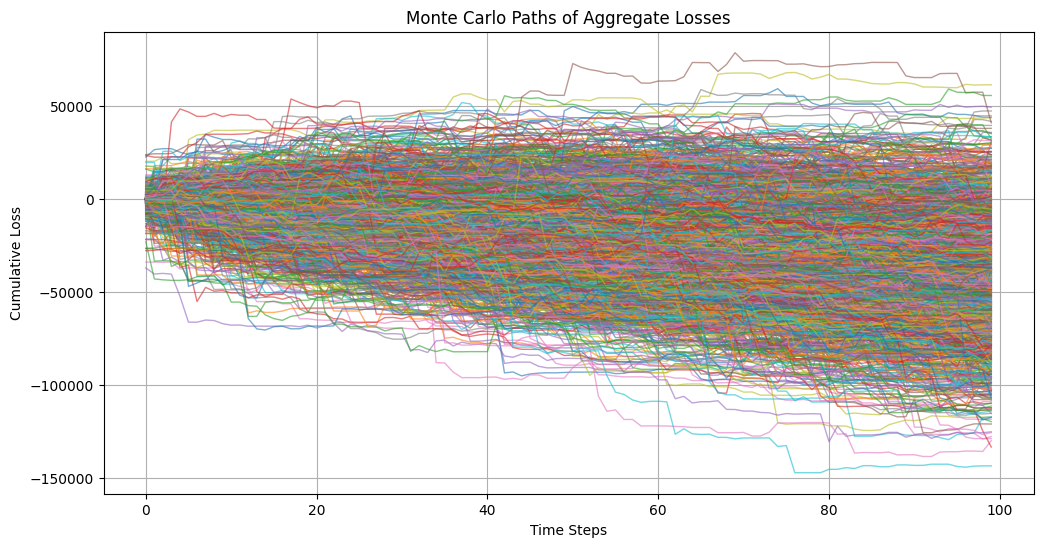

In [7]:
import matplotlib.pyplot as plt

num_steps = 100  
num_paths = len(sample_losses) // num_steps

reshaped_losses = sample_losses[:num_steps * num_paths].reshape(num_steps, num_paths)
cumulative_losses = np.cumsum(reshaped_losses, axis=0)

plt.figure(figsize=(12, 6))
plt.plot(cumulative_losses, alpha=0.6, lw=1)
plt.title("Monte Carlo Paths of Aggregate Losses")
plt.xlabel("Time Steps")
plt.ylabel("Cumulative Loss")
plt.grid()
plt.show()

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

losses = np.array(sample)

kde = gaussian_kde(losses)

x_values = np.linspace(min(losses), max(losses), 1000)
kde_values = kde(x_values)

plt.figure(figsize=(10, 6))
plt.plot(x_values, kde_values, color='blue', label='KDE of Losses')
plt.title("Smoothed Loss Distribution (KDE)")
plt.xlabel("Total Loss")
plt.ylabel("Density")
plt.legend()
plt.show()

NameError: name 'sample' is not defined

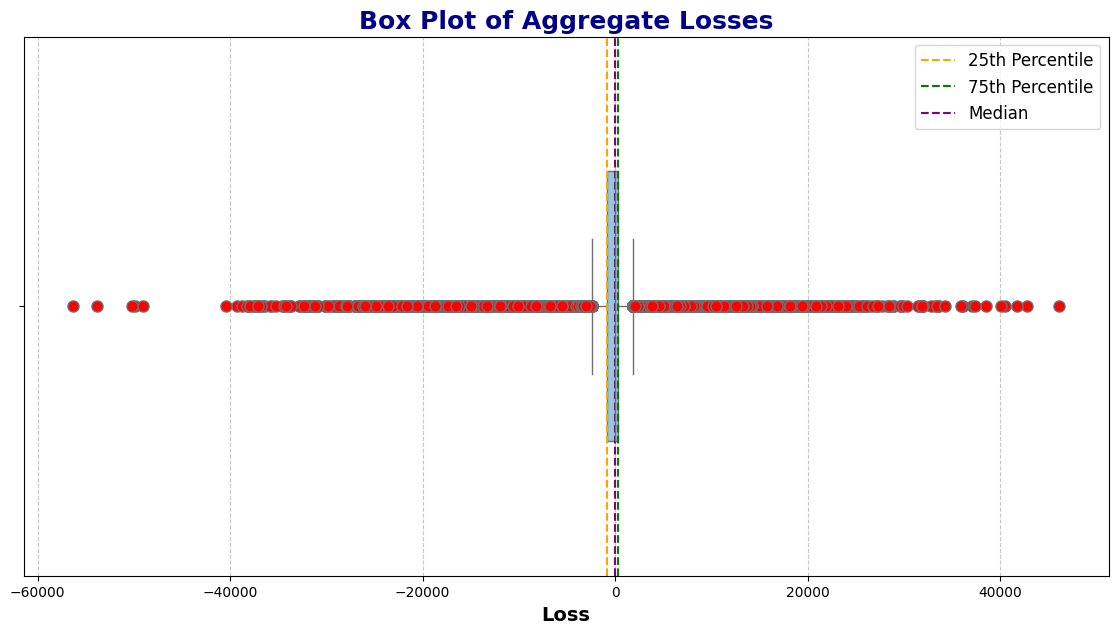

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

plt.figure(figsize=(14, 7))

sns.boxplot(
    x=sample_losses,
    color='skyblue', 
    width=0.5, 
    flierprops={"marker": "o", "markersize": 8, "markerfacecolor": "red"}
)


plt.title("Box Plot of Aggregate Losses", fontsize=18, fontweight="bold", color="darkblue")
plt.xlabel("Loss", fontsize=14, fontweight="bold")
plt.grid(axis='x', linestyle="--", alpha=0.7)


plt.axvline(np.percentile(sample_losses, 25), color="orange", linestyle="--", label="25th Percentile")
plt.axvline(np.percentile(sample_losses, 75), color="green", linestyle="--", label="75th Percentile")
plt.axvline(np.median(sample_losses), color="purple", linestyle="--", label="Median")

plt.legend(fontsize=12)
plt.show()